# _k_ nearest neighbours (kNN)

The purpose of this notebook is to understand the kNN algorithm by implementing it low level - NumPy ONLY!

The kNN algorithm can be used both for classification and  regression. 
* it start with calculating the distance of a given point $x$ to all other points in the data set. 
* Then, it finds the _k_ nearest points closest to $x$, and assigns the new point $x$ to the majority class of the _k_ nearest points _(classification)_. 

So, for example, if two of the _k_=3 closest points to $x$ were red while one is blue, $x$ would be classified as red.

On the other hand in _regression_, we see the labels as continuous variables and assign the label of a data point $x$ as the mean of the labels of its _k_ nearest neighbours. 

In [1]:
#dependencies 
import numpy as np
from sklearn.datasets import make_classification, fetch_california_housing
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Reminder of axes-wise

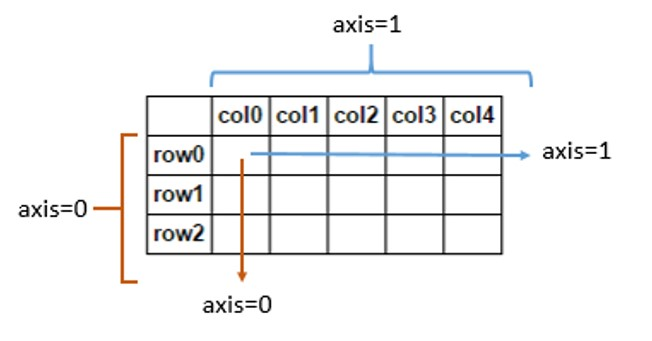

This makes alot more sense! 
* axis = 0 are the rows (as expected) so we sum row-wise i.e down the rows! 
* axis = 1 are the columns so we sum column-wise i.e. across the coulmns!

In [24]:
# function which computes Euclidean Dist
def euclidian_distance(p, q):
    return np.sqrt(np.sum((p-q)**2, axis=1)) 

In [27]:
p = np.array([1, 2]).reshape(-1,1)
q = np.array([5, 3]).reshape(-1,1)

print(p)
print('')
print(q)
print('')
print(euclidian_distance(p,q))

[[1]
 [2]]

[[5]
 [3]]

[4. 1.]


In [30]:
p = np.array([[1,2,3], [4,5,6]])
print(p)
print('')
print(p.shape)

[[1 2 3]
 [4 5 6]]

(2, 3)


In [31]:
q = np.array([[7,8,9], [10, 11, 12]])
print(q)

[[ 7  8  9]
 [10 11 12]]


In [33]:
print(euclidian_distance(p,q))

# the reason it is brought up (i.e. side by side is because we are dealing with columns! ie 1st coolumn then second column)

[10.39230485 10.39230485]


# KNN: Classification

In [93]:
# create data - (100, 2) with three classes
X_class, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1,
                                 n_classes=3, random_state=15)

In [37]:
# Standardise data - Key for KNN to ensure there are no domainaces in certain predictor vairables (columns)
def standardise(X):
  mu = np.mean(X, 0)
  sigma = np.std(X, 0)
  X_std = (X - mu) / sigma
  return X_std

In [38]:
X = standardise(X_class)

In [40]:
X.shape

(100, 2)

In [41]:
y.shape

(100,)

In [46]:
print((y[:, np.newaxis]).shape)

(100, 1)


In [96]:
# stacking data X and labels y into one matrix
#need to expand y with a new axis (since its only 1-dim)
data = np.hstack((X, y[:, np.newaxis]))

# shuffling the rows        
np.random.shuffle(data)

# we split train to test as 70:30
split_rate = 0.7
#np.split takes an indices_or_sections arg which takes an array giving where you want the splits
# i.e. For example, [2, 3] would, for axis=0, result in ary[:2], ary[2:3], ary[3:] - see docs for reminder! 
train, test = np.split(data, indices_or_sections=[int(split_rate*(data.shape[0]))])

#then seperate the data out into X and Y
X_train = train[:,:-1] # up to the last column
y_train = train[:, -1] # just the last column

X_test = test[:,:-1]
y_test = test[:, -1]

#ensure the data are intergers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

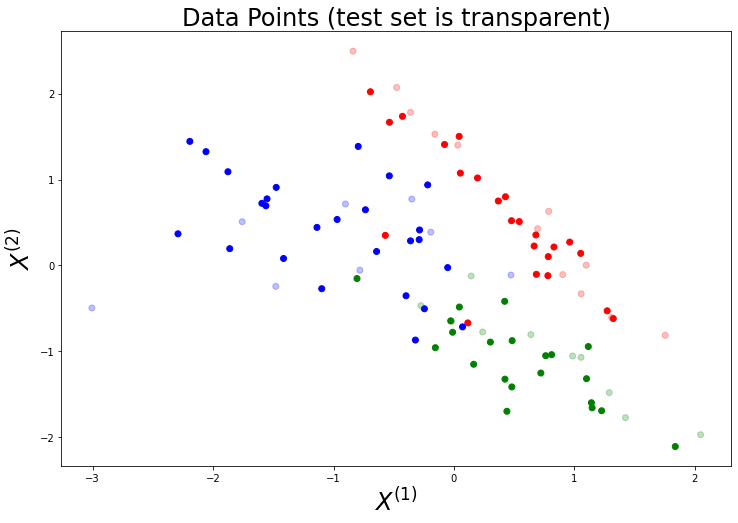

In [98]:
# define colormaps
cm = plt.cm.RdBu
cm_bright = ListedColormap(['blue', 'red', 'green'])

# visual exploration
plt.figure(figsize=(12,8))
plt.xlabel(r'$X^{(1)}$', size=24)
plt.ylabel(r'$X^{(2)}$', size=24)
plt.title('Data Points (test set is transparent)', size=24)
#plot the training set 
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
# plot the test set - alpha sets transparency
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.25) 
plt.show()

In [99]:
# calucluate k-nearest neighbours
def k_neighbours(X_test, k=5, return_distance=False):
    n_neighbours = k
    dist = []
    neigh_ind = []

   # compute distance from each point x_text in X_test to all points in X_train 
    point_dist = [euclidian_distance(x_test, X_train) for x_test in X_test]
    

   # determine which k training points are closest to each test point
    for row in point_dist:
        
        # take a row and enumerate it (i.e. each elm in row is now a tuple--> (ind, dist)) 
        # we then sort the row based on the size of the dist (i.e. x[1])
        # then we only want the top k ones so [:k]
        sorted_neigh = sorted(enumerate(row), key=lambda x: x[1])[:k]
        
        #split the indices and distances from the tuple into seperate lists
        ind_list = [tup[0] for tup in sorted_neigh]
        dist_list = [tup[1] for tup in sorted_neigh]
        
        #append to full lists 
        dist.append(dist_list)
        neigh_ind.append(ind_list)

  # return distances together with indices of k nearest neighbouts
    if return_distance:
        return np.array(dist), np.array(neigh_ind)

    return np.array(neigh_ind)

#### We have Our K Nearest neighbour - Now lets get prediction based on these

We know which _k_ neighbours are closest to our test points so lets predict the labels by counting the number of occuernces of a label within our neighbourhood

In [100]:
def predict(X_test, y_train, k=5):
    
  # each of the k neighbours contributes equally to the classification of any data point in X_test  
  neighbours = k_neighbours(X_test, k=k)
    
  # count number of occurences of label with np.bincount and choose the label that has most with np.argmax 
  y_pred = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours]) ## <-- SOLUTION

  return y_pred

#### Now we have our predictions we need a way of scoring how well the prediction is

To evaluate the algorithm we compute the mean accuracy by counting how many of the test points have been classified correctly and dividing this number by the total number of data points in our test set.

In [101]:
def score(X_test, y_test, y_train, k=5):
    
    y_pred = predict(X_test, y_train, k=k)
    
    #compute the average of the number of correct predictions
    return np.float(sum(y_pred==y_test))/ float(len(y_test))

In [102]:
k = 8

# remember KNN is a supervised Learning Algorithum - hence have labels for test set too!
print('Train set mean accuracy:', score(X_train, y_train, y_train, k=k))
print('Test set mean accuracy:', score(X_test, y_test, y_train, k=k))

Train set mean accuracy: 0.9428571428571428
Test set mean accuracy: 0.8666666666666667
